# Installations:

In [ ]:
import torch
from torch import Tensor
print(torch.__version__)

2.1.0+cu121


In [ ]:
# Install required packages.
import os
os.environ['TORCH'] = torch.__version__

!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 51.3 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 69.0 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/nightly/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 2.1 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-qh2u1n26
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-qh2u1n26
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 3a56d4bfd50f16515138be73b748fa586747c3ef
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.4.0-py3-none-any.whl 

# Mount your Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports:

In [ ]:
import torch_geometric
import numpy as np
import torch
import torch_geometric.datasets as datasets
import torch_geometric.data as Data
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as transforms
import networkx as nx
from torch_geometric.utils.convert import to_networkx
#from torch_geometric.data import HeteroData

In [ ]:
import numpy as np
import torch
import pandas as pd

In [ ]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# Loading the data:

In [ ]:
!git clone https://github.com/MeysamAmirsardari/VAME

Cloning into 'VAME'...
remote: Enumerating objects: 1488, done.
remote: Counting objects: 100% (338/338), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 1488 (delta 283), reused 258 (delta 255), pack-reused 1150
Receiving objects: 100% (1488/1488), 109.84 MiB | 7.31 MiB/s, done.
Resolving deltas: 100% (888/888), done.
Updating files: 100% (45/45), done.


# Modeling the graph:

In [ ]:
def set_nodes(Xs, Ys, CLs, off_idx, land_mark_num, epoch_len, encoders=None):
  x = torch.tensor([])

  for n in range(epoch_len):
    for i in range(land_mark_num):
      step = torch.tensor([[float(Xs[i, n + off_idx])],
                           [float(Ys[i, n + off_idx])],
                           [float(CLs[i, n + off_idx])]],
                          dtype=torch.float)
      x = torch.cat((x, step.T), dim=0)
  return x

In [ ]:
num_landmarks = num_keypoints

edge_index = []
edge_attr = []

# Connect each landmark to all other landmarks in the same layer
for layer in range(num_layers):
    start = layer * num_landmarks
    layer_edges = [(i, j) for i in range(start, start + num_landmarks) for j in range(start, start + num_landmarks) if i != j]
    layer_edges = [[edge[0], edge[1]] for edge in layer_edges]
    edge_index.extend(layer_edges)
    edge_attr.extend([edj_attr_matrix[i % num_landmarks, j % num_landmarks] for i, j in layer_edges])

# Connect each landmark to the same landmark in the next layer
for layer in range(num_layers - 1):
    start1 = layer * num_landmarks
    start2 = (layer + 1) * num_landmarks
    layer_edges = [[i, j] for i in range(start1, start1 + num_landmarks) for j in range(start2, start2 + num_landmarks) if i % num_landmarks == j % num_landmarks]
    edge_index.extend(layer_edges)
    edge_attr.extend([1 for _ in layer_edges])

edge_index = torch.tensor(edge_index).double().t().contiguous()
edge_attr = torch.tensor(edge_attr).unsqueeze(-1)

In [ ]:
def get_graph_list(path, edge_index, edge_attr, num_keypoints = 6, overlap = 0.5, num_layers = 120, step = 10):
    df = pd.read_csv(path, index_col=None, header=0, encoding="utf-8")
    temp = df.head(1).values.tolist()[0]

    labels = []
    for i in range(1, num_keypoints*3, 3):
      labels.append(temp[i])

    df = pd.read_csv(path, index_col=None, header=1, encoding="utf-8").drop(index=range(2))


    Xs = []
    Ys = []
    CLs = []

    for l in labels:
      Xs.append(df[l].values.astype(float).tolist())
      Ys.append(df[l+'.1'].values.astype(float).tolist())
      CLs.append(df[l+'.2'].values.astype(float).tolist())

    Xs = np.array(Xs)
    Ys = np.array(Ys)
    CLs = np.array(CLs)

    weighted_mean = np.sum(Xs * CLs, axis=1) / np.sum(CLs, axis=1)
    norm_Xs = (Xs - weighted_mean[:, np.newaxis])/np.max(Xs)

    weighted_mean = np.sum(Ys * CLs, axis=1) / np.sum(CLs, axis=1)
    norm_Ys = (Ys - weighted_mean[:, np.newaxis])/np.max(Ys)

    Xs_cov = np.corrcoef(norm_Xs)
    Ys_cov = np.corrcoef(norm_Ys)
    edj_attr_matrix = (np.square(Ys_cov) + np.square(Xs_cov))/2

    len = df.shape[0]-1
    graph_list = []
    order = []
    land_mark_num = num_keypoints
    count = 0

    for i in range(1, len-epoch_len, step):
      x = set_nodes(norm_Xs, norm_Ys, CLs, i, land_mark_num, epoch_len)
      data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
      graph_list.append(data)
      count = count + 1
      order.append((count, i))

    graph_num = count

    return graph_list

In [ ]:
root_path = '/content/VAME/examples/'
mouse-1-1.csv

num_keypoints = 6
num_layers = 120
epoch_len = num_layers
overlap = 0.5

graph_lists = []

for i in range(4):
  temp = []
  for j in range(2):
    path = root_path + 'mouse-' + str(i+1) + '-' + str(j+1) + '.csv'
    temp.append(get_graph_list(path, edge_index, edge_attr))
  graph_lists.append(temp)

# Richening the data:

In [ ]:
import torch.nn.functional as F
from torch_geometric.data import Data

# Function to calculate distances between body parts in the same frame
def calculate_distances(x):
    num_nodes = x.shape[0] // 6
    distances = []
    for i in range(num_nodes):
        node_positions = x[i * 6 : (i + 1) * 6, :2]  # Extract X and Y coordinates
        pairwise_distances = torch.norm(node_positions[:, None, :] - node_positions, dim=-1)
        distances.append(pairwise_distances.view(-1, 1))
    return torch.cat(distances, dim=1)

# Function to calculate angles between body parts in the same frame
def calculate_angles(x):
    num_nodes = x.shape[0] // 6
    angles = []
    for i in range(num_nodes):
        node_positions = x[i * 6 : (i + 1) * 6, :2]  # Extract X and Y coordinates
        pairwise_vectors = node_positions[:, None, :] - node_positions
        pairwise_angles = torch.atan2(pairwise_vectors[:, :, 1], pairwise_vectors[:, :, 0])
        angles.append(pairwise_angles.view(-1))
    return torch.cat(angles, dim=1)

# Function to add features to the x matrix
def add_features_to_x(x):
    velocity = F.pad(x[:, :2].diff(dim=0), (0, 0, 0, 1))  # Pad with zeros to match size
    acceleration = F.pad(x[:, :2].diff(dim=0, n=2), (0, 0, 0, 2))  # Pad with zeros to match size

    # Concatenate along the second dimension (columns)
    richer_features = torch.cat([x, velocity, acceleration], dim=1)

    # distances = calculate_distances(x)
    # angles = calculate_angles(x)

    # Concatenate distances and angles along the second dimension
    # richer_features = torch.cat([richer_features, distances, angles], dim=1)

    return richer_features

graph_list2 = []
for i in range(graph_num):
    g = graph_list[i]
    g.x = add_features_to_x(g.x)
    graph_list2.append(g)


In [ ]:
import networkx as nx

# Function to calculate graph theoretical features
def calculate_graph_theoretical_features(edge_index, num_nodes):
    # Create a NetworkX graph from edge_index
    G = nx.Graph()
    G.add_edges_from(edge_index.t().numpy())

    # Calculate graph theoretical features
    degree_centrality = np.array(list(nx.degree_centrality(G).values()))
    closeness_centrality = np.array(list(nx.closeness_centrality(G).values()))
    betweenness_centrality = np.array(list(nx.betweenness_centrality(G).values()))

    return degree_centrality, closeness_centrality, betweenness_centrality

# Function to add graph theoretical features to the x matrix
def add_graphical_features(x, edge_index):
    num_nodes = x.shape[0] // 6
    degree_centrality, closeness_centrality, betweenness_centrality = calculate_graph_theoretical_features(edge_index, num_nodes)

    # Replicate features for each body part in the same frame
    degree_centrality_replicated = torch.tensor(np.tile(degree_centrality, 6)).float().view(-1, 1)
    closeness_centrality_replicated = torch.tensor(np.tile(closeness_centrality, 6)).float().view(-1, 1)
    betweenness_centrality_replicated = torch.tensor(np.tile(betweenness_centrality, 6)).float().view(-1, 1)

    graphical_features = torch.cat([degree_centrality_replicated, closeness_centrality_replicated, betweenness_centrality_replicated], dim=1)
    richer_features = torch.cat([x, graphical_features], dim=1)

    return richer_features

graph_list3 = []
for i in range(graph_num):
    g = graph_list2[i]
    g.x = add_graphical_features(g.x, edge_index)
    graph_list3.append(g)

In [ ]:
graph_list = graph_list2

* **Create and save the dataset:**

In [ ]:
from torch_geometric.data import DataLoader

batch_size = 32

loaders = []

for i in range(4):
  temp = []
  for j in range(2):
    dataloader = DataLoader(graph_list[i,j], batch_size=batch_size, shuffle=True)
    temp.append(dataloader)
    name = 'mouse' + str(i) + '_' + str(j)
    torch.save(loader, '/content/drive/MyDrive/loader_for_' + name + '.pth')
  loaders.append(temp)

In [ ]:
loaders = []

for i in range(4):
  temp = []
  for j in range(2):
    name = 'mouse' + str(i) + '_' + str(j)
    dataloader = torch.load('/content/drive/MyDrive/loader_for_' + name + '.pth')
    temp.append(dataloader)
  loaders.append(temp)

[Data(x=[2160, 3], edge_index=[2, 38862], edge_attr=[38862, 1]), Data(x=[2160, 3], edge_index=[2, 38862], edge_attr=[38862, 1]), Data(x=[2160, 3], edge_index=[2, 38862], edge_attr=[38862, 1]), Data(x=[2160, 3], edge_index=[2, 38862], edge_attr=[38862, 1]), Data(x=[2160, 3], edge_index=[2, 38862], edge_attr=[38862, 1]), Data(x=[2160, 3], edge_index=[2, 38862], edge_attr=[38862, 1]), Data(x=[2160, 3], edge_index=[2, 38862], edge_attr=[38862, 1]), Data(x=[2160, 3], edge_index=[2, 38862], edge_attr=[38862, 1]), Data(x=[2160, 3], edge_index=[2, 38862], edge_attr=[38862, 1]), Data(x=[2160, 3], edge_index=[2, 38862], edge_attr=[38862, 1]), Data(x=[2160, 3], edge_index=[2, 38862], edge_attr=[38862, 1]), Data(x=[2160, 3], edge_index=[2, 38862], edge_attr=[38862, 1]), Data(x=[2160, 3], edge_index=[2, 38862], edge_attr=[38862, 1]), Data(x=[2160, 3], edge_index=[2, 38862], edge_attr=[38862, 1]), Data(x=[2160, 3], edge_index=[2, 38862], edge_attr=[38862, 1]), Data(x=[2160, 3], edge_index=[2, 38862]

# Training the Attentional Variational Graph Autoencoder:

**Model: MultiHead Transormer**

**Encoder: GAT-50**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, VGAE, GMMConv
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GAE, VGAE, GCNConv, TransformerConv
from torch_geometric.utils import to_dense_batch
from torch_geometric.nn import global_mean_pool
import numpy as np

# Define the number of epochs to train for
num_epochs = 200

# Define the batch size for the dataloader
batch_size = 32

# Define the number of nodes and features in each node
num_nodes = num_keypoints*num_layers
num_features = 7

# Define the number of dimensions in the latent variable
hidden_dim = 24
output_dim = 18
input_dim = 7

# Define the device to use for training (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the encoder and decoder architectures for the VAE

class Encoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_gmm_layers=1):
        super(Encoder, self).__init__()
        torch.manual_seed(12345)
        self.gat1 = GATConv(input_dim, hidden_dim)
        self.gat2 = GATConv(hidden_dim, hidden_dim)
        self.gat3 = GATConv(hidden_dim, hidden_dim)
        self.gmm_layers = torch.nn.ModuleList()

        for i in range(num_gmm_layers):
            self.gmm_layers.append(GMMConv(hidden_dim, hidden_dim, kernel_size=10, dim=1))

        self.conv_mu = GCNConv(hidden_dim, hidden_dim)
        self.lin = torch.nn.Linear(hidden_dim, output_dim)
        self.lin_mean = torch.nn.Linear(hidden_dim, output_dim)
        self.lin_logstd = torch.nn.Linear(hidden_dim, output_dim)
        self.global_pool = torch.nn.Linear(hidden_dim, output_dim)


    def forward(self, x, edge_index, edge_attr, batch):
        x = self.gat1(x, edge_index, edge_attr=edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        x = self.gat3(x, edge_index, edge_attr=edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        for gmm_layer in self.gmm_layers:
          x = gmm_layer(x, edge_index, edge_attr)
          x = F.elu(x)
          x = F.dropout(x, p=0.4, training=self.training)

        # x = self.gat2(x, edge_index, edge_attr=edge_attr)
        # x = F.elu(x)
        # x = F.dropout(x, p=0.4, training=self.training)

        # x = self.gat2(x, edge_index, edge_attr=edge_attr)
        # x = F.elu(x)
        # x = F.dropout(x, p=0.4, training=self.training)

        # x = global_add_pool(x, batch)
        # x, batch = to_dense_batch(x, batch=batch)

        x = self.conv_mu(x, edge_index)

        x = F.dropout(x, p=0.4, training=self.training)
        z = global_mean_pool(x, batch)
        # x = self.global_pool(x)
        z = self.lin(z)
        z_log_std = self.lin_logstd(x)
        z_mean = self.lin_mean(x)

        return z, z_mean, z_log_std

**Encoder: GAT+bn+sp**

**Decoder and Loss Func:**

In [ ]:
class Decoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.lin1 = torch.nn.Linear(input_dim, hidden_dim)
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.lin3 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, z, edge_index, edge_attr):
        z = self.lin1(z)
        z = F.relu(z)
        z = self.conv1(z, edge_index)
        z = F.relu(z)
        z = self.conv2(z, edge_index)
        z = F.relu(z)
        z = self.lin3(z)
        z = torch.sigmoid(z)
        return z


class AttentionalGraphAutoencoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AttentionalGraphAutoencoder, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, output_dim)
        self.decoder = Decoder(output_dim, hidden_dim, input_dim)

    def forward(self, x, edge_index, edge_attr, batch):
        z, z_mean, z_log_std = self.encoder(x, edge_index, edge_attr, batch)
        z = z_mean + torch.randn_like(z_log_std) * torch.exp(0.5 * z_log_std)
        x_hat = self.decoder(z, edge_index, edge_attr)
        return x_hat, z_mean, z_log_std

def loss_function(x_hat, z_mean, x, z_log_std):
    # kl_loss = 0#0.5 * torch.sum(z_log_std - output**2 - 1, dim=1)
    kl_loss = -0.5 * torch.sum(1 + z_log_std - z_mean.pow(2) - z_log_std.exp())
    recon_loss = F.mse_loss(x_hat, x)
    print(kl_loss)
    print(recon_loss)
    loss = recon_loss + 0.1*kl_loss
    return loss
# def loss_function(x_hat, x, z_mean, z_log_std, alpha):
#     kl_loss = 0.5 * torch.sum(z_log_std + torch.exp(z_log_std) - z_mean**2 - 1, dim=1)
#     recon_loss = F.mse_loss(x_hat, x)
#     loss = recon_loss + alpha * kl_loss
#     return loss

def kl_loss(z_mean, z_log_std):
    kl_div = -0.5 * torch.sum(1 + 2*z_log_std - z_mean.pow(2) - (2*z_log_std).exp(), dim=1)
    return torch.mean(kl_div)


**Training the model:**

In [ ]:
import torch_geometric.utils as utils

train_losses = []
val_losses = []
train_accs = []
val_accs = []
loss_list = []

# Define the number of epochs to train for
num_epochs = 300

# Define the batch size for the dataloader
batch_size = 32

# Define the number of nodes and features in each node
num_nodes = num_keypoints*num_layers
num_features = 7

# Define the number of dimensions in the latent variable
hidden_dim = 68
output_dim = 60
input_dim = 7

model_list = []

# Train the GVAE model
for i in range(4):
  dataloader = loaders[i,0].to(device)
  model = AttentionalGraphAutoencoder(input_dim, hidden_dim, output_dim).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

  print('Modle' + str(i+1) + '-th' + '*******************************************')

  for epoch in range(num_epochs):
      train_loss = 0.0
      train_acc = 0.0
      val_loss = 0.0
      val_acc = 0.0

      for batch in dataloader:
          batch = batch.to(device)
          optimizer.zero_grad()
          x_hat, z_mean, z_log_std = model(batch.x, batch.edge_index.long(), batch.edge_attr.long(), batch.batch)
          loss = F.mse_loss(x_hat, batch.x)
          loss = loss + 0.1 * kl_loss(z_mean, z_log_std)

          loss.backward()
          optimizer.step()

          train_loss += loss.item() * batch.num_graphs
      train_loss /= graph_num
      train_losses.append(train_loss)
      print(f'Epoch {epoch+1}/{num_epochs}: Loss={loss.item()}')
      loss_list.append(loss.item())

  state_dict = model.state_dict()
  torch.save(state_dict, '/content/drive/MyDrive/vame_data_test_GAT2_gmm2_mouse'+str(i+1)+'.pt')
  print('models saved')

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/450: Loss=0.045655757188797
Epoch 2/450: Loss=0.045951247215270996
Epoch 3/450: Loss=0.041883982717990875
Epoch 4/450: Loss=0.03573231026530266
Epoch 5/450: Loss=0.03318475931882858
Epoch 6/450: Loss=0.032188884913921356
Epoch 7/450: Loss=0.038341421633958817
Epoch 8/450: Loss=0.036193348467350006
Epoch 9/450: Loss=0.03953757509589195
Epoch 10/450: Loss=0.04665978252887726
Epoch 11/450: Loss=0.04533827304840088
Epoch 12/450: Loss=0.04666880518198013
Epoch 13/450: Loss=0.028875913470983505
Epoch 14/450: Loss=0.036207158118486404
Epoch 15/450: Loss=0.030802499502897263
Epoch 16/450: Loss=0.045526519417762756
Epoch 17/450: Loss=0.034695640206336975
Epoch 18/450: Loss=0.04342418909072876
Epoch 19/450: Loss=0.03841063380241394
Epoch 20/450: Loss=0.04082506522536278
Epoch 21/450: Loss=0.038955193012952805
Epoch 22/450: Loss=0.04600951820611954
Epoch 23/450: Loss=0.03688837215304375
Epoch 24/450: Loss=0.033690113574266434
Epoch 25/450: Loss=0.04035719856619835
Epoch 26/450: Loss=0.028

**Cleaning the memory!**

In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()

# Evaluation:

In [ ]:
model.eval()

AttentionalGraphAutoencoder(
  (encoder): Encoder(
    (gat1): GATConv(3, 68, heads=1)
    (gat2): GATConv(68, 68, heads=1)
    (gat3): GATConv(68, 68, heads=1)
    (gmm_layers): ModuleList(
      (0): GMMConv(68, 68, dim=1)
    )
    (conv_mu): GCNConv(68, 68)
    (lin): Linear(in_features=68, out_features=60, bias=True)
    (lin_mean): Linear(in_features=68, out_features=60, bias=True)
    (lin_logstd): Linear(in_features=68, out_features=60, bias=True)
    (global_pool): Linear(in_features=68, out_features=60, bias=True)
  )
  (decoder): Decoder(
    (lin1): Linear(in_features=60, out_features=68, bias=True)
    (conv1): GCNConv(68, 68)
    (conv2): GCNConv(68, 68)
    (lin2): Linear(in_features=68, out_features=68, bias=True)
    (conv3): GCNConv(68, 68)
    (lin3): Linear(in_features=68, out_features=3, bias=True)
  )
)

**To save the trained model:**

In [ ]:
state_dict = model.state_dict()

# Save the state dictionary to a file
torch.save(state_dict, '/content/drive/MyDrive/vame_data_test_GAT3_450_2_14_fine.pt')

**Loading the saved model:**

In [ ]:
model = AttentionalGraphAutoencoder(input_dim, hidden_dim, output_dim).to(device)

# Load the saved state dictionary into the model
state_dict = torch.load('/content/drive/MyDrive/vame_data_test_GAT1_GMMConv2_50_20_24_9_fine.pt', map_location=torch.device('cpu'))
# model.load_state_dict(state_dict)

# Embedding the graphs and saving:

In [ ]:
# Embed the input graphs using the trained VAE
embeddings = []

for graph in graph_list:
    graph = graph.to(device)
    with torch.no_grad():
        output = model.encoder(graph.x, graph.edge_index.long(), graph.edge_attr.long(), graph.batch)
    embeddings.append(output[0].cpu().numpy())

embeddings = np.array(embeddings)

In [ ]:
np.save('/content/drive/MyDrive/embeddings_vame_data_test_GAT3_450_2_14_fine.npy', embeddings)

Reload:

In [ ]:
embeddings = np.load('/content/drive/MyDrive/embeddings_vame_data_test_GAT1_GMMConv2_50_20_24_9_fine.npy')
# embedded_3d = np.load('/content/drive/MyDrive/node_embeddings_3D.npy')

In [ ]:
embeddings2 = np.array(embeddings[:,0,:])

Visualizing the embedded data:

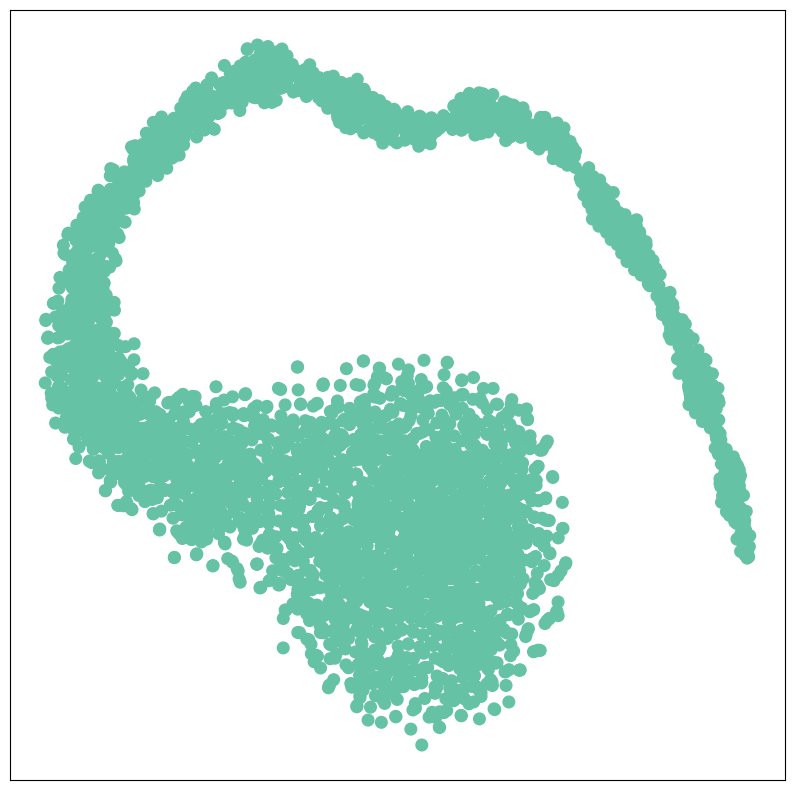

In [ ]:
visualize(torch.tensor(embeddings2), color=np.zeros([1,embeddings2.shape[0]]))

# Clustering the Graphs:

In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture

# Load the embedded graph data
# embeddings = np.load('embeddings.npy')

# Set the number of clusters
num_clusters = 10

# Initialize the GMM model
gmm = GaussianMixture(n_components=num_clusters)

# Fit the GMM model to the embedded data
gmm.fit(embeddings2)

# Predict the cluster labels for the embedded data
cluster_labels = gmm.predict(embeddings2)
print(cluster_labels)

[0 0 0 ... 0 0 0]


In [ ]:
from sklearn.mixture import BayesianGaussianMixture


# Number of clusters you want to fit
num_clusters = 8  # Adjust this based on your requirements

# Fit a Gaussian Mixture Model
gmm = BayesianGaussianMixture(n_components=num_clusters, random_state=42)
gmm.fit(embeddings2)

# Extract the cluster centers (means)
cluster_centers = gmm.means_
cluster_labels = gmm.predict(embeddings2)

# Print the cluster centers
print("Cluster Centers:")
print(cluster_centers)

# Save cluster centers to a CSV file

np.savetxt('cluster_centers.csv', cluster_centers, delimiter=',', comments='')
np.savetxt('samples_labels.csv', cluster_labels, delimiter=',', comments='')

# print(f"Cluster centers saved to {csv_filename}.")


Cluster Centers:
[[ 6.00653574e-02  1.03465082e-01 -1.32926015e-01  1.76924630e-01
  -8.55144696e-02  2.41787864e-01 -1.25313664e-02 -8.22466239e-02
   7.41763554e-02 -3.93644899e-02  5.60710404e-02 -2.13136261e-05
  -3.88080991e-02  5.45282241e-02  6.40286270e-02 -2.27710530e-01
  -1.00652810e-01  1.29387355e-02 -1.70551289e-01 -9.26106561e-02
  -5.46556141e-02  2.71264862e-03 -3.62421710e-02  1.92028572e-02
  -2.58603171e-02 -1.15228984e-01  1.93816542e-01  4.79531618e-02
   5.17424512e-02 -5.42958172e-02 -1.23122891e-02  1.63839504e-01
   2.33119116e-02 -2.05353628e-01 -7.06547167e-02 -4.33785256e-02
  -2.99299085e-02 -3.63344755e-02  7.72909951e-02  2.74427903e-02
   8.35800610e-03 -3.44185949e-02 -1.14118879e-01 -5.06610271e-02
   1.23370718e-01 -9.20052390e-02  8.31765601e-02 -3.70324371e-01
   1.32201690e-01  1.59418321e-01  1.66548621e-01  3.14670457e-02
   1.25486428e-01 -6.60577608e-02 -3.09774395e-02  1.51121295e-01
  -4.36783236e-02  3.40116760e-02  2.31121612e-01 -1.361470

/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


In [ ]:
!pip install -q hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 94.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import hdbscan

# Assuming your 6x1000 array is called `embedded_graph`
# Transpose the array so that each row represents a data point and each column represents a feature
embedded_graph = embeddings2

# Cluster the data using HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
cluster_labels2 = clusterer.fit_predict(embedded_graph)

# Print the number of clusters found
# num_clusters = len(set(cluster_labels2)) - (1 if -1 in cluster_labels2 else 0)
print(f"Number of clusters: {num_clusters}")

# Print the cluster labels for each data point
print("Cluster labels:")
print(cluster_labels2)

Number of clusters: 8
Cluster labels:
[-1 -1  9  9  9  9 -1 -1 -1 -1 -1 -1 -1 -1  5  6  5 -1 -1 -1 -1  3 -1  9
 -1 -1  9  9 -1 -1  5  5 -1  3 -1 -1  9  6 -1 -1 -1 -1  1  1  1  1  1  1
  2  6  5  5 -1 -1  2 -1  1  1  1  1 -1 -1 -1 -1 -1 -1  5  3 -1 -1 -1  9
  9  9  9 -1 -1 -1 -1 -1  9  9 -1  3  1 -1 -1  2 -1 -1 -1 -1 -1 -1  9  9
  9  9 -1  3 -1  4  3  3 -1 -1 -1 -1  1 -1 -1  1 -1  1  1  1  1  1  1  1
 -1 -1 -1 -1 -1 -1 -1 -1  9  9  9 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1  1 -1
  5  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  4 -1  9  9  9  9  9  9  9
 -1 -1 -1 -1  3  4  9 -1  3  3  3 -1 -1 -1 -1 -1 -1  6  6  6  6  5  5  5
  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  9  9  9  9  9  9  9  9  9
  9  9  9  9 -1  3  1  2  2 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1
  5 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1 -1 -1  3 -1 -1 -1  1
  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2 -1 -1 -1
  5 -1  9  9  9 -1  9  9  9 -1 -1  9  9  9 -1 -1  2 -1 -1 -1 -1 -1 -1 -1
 -1  1  1  1 

In [ ]:
import numpy as np
from sklearn.cluster import KMeans

# Load the embedded graph data
# embeddings = np.load('embeddings.npy')

# Set the number of clusters
num_clusters = 10

# Initialize the KMeans model
kmeans = KMeans(n_clusters=num_clusters)

# Fit the KMeans model to the embedded data
kmeans.fit(embeddings2)

# Predict the cluster labels for each data point
cluster_labels = kmeans.predict(embeddings2)

# Print the cluster labels
print(cluster_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[4 4 4 ... 0 7 7]


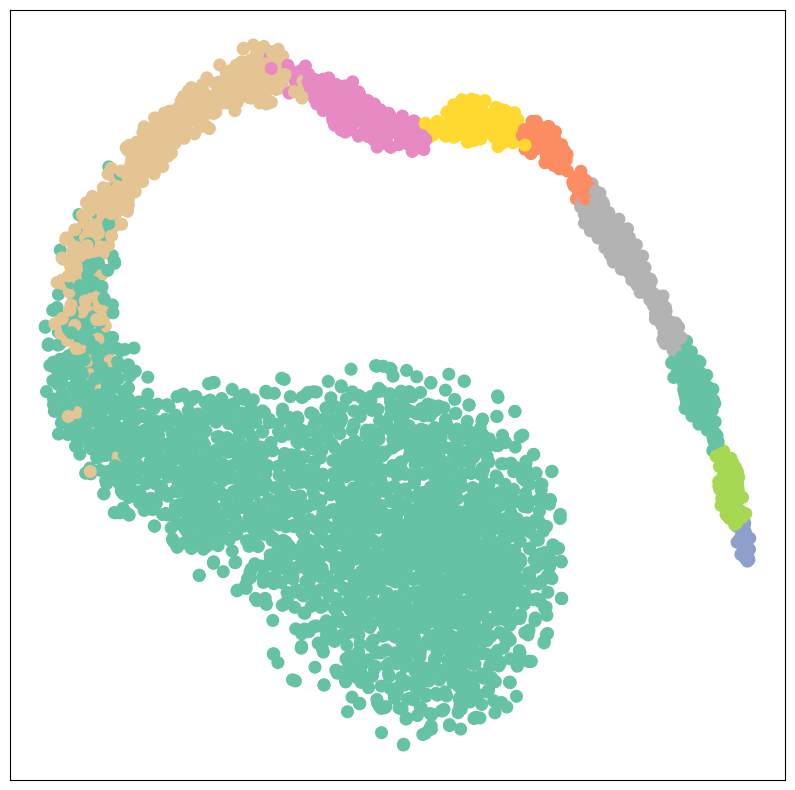

In [ ]:
visualize(torch.tensor(embeddings2), color=cluster_labels)

# Analysis:

transition matrix:

In [ ]:
states = cluster_labels
# Get unique state values
unique_states = np.unique(cluster_labels)

# Calculate the size of the transition matrix
matrix_size = 10

# Create an empty transition matrix
transition_matrix = np.zeros((matrix_size, matrix_size))

# Calculate the number of transitions between each pair of states
for i in range(graph_num - 1):
    current_state = states[i]
    next_state = states[i + 1]
    current_state_index = np.where(unique_states == current_state)[0][0]
    next_state_index = np.where(unique_states == next_state)[0][0]
    transition_matrix[current_state_index][next_state_index] += 1

# Normalize the transition matrix
row_sums = np.sum(transition_matrix, axis=1)
transition_matrix = np.divide(transition_matrix, row_sums[:, np.newaxis])

print(transition_matrix)

[[0.93214863 0.         0.         0.         0.         0.00121163
  0.         0.         0.         0.06663974]
 [0.         0.59090909 0.         0.17045455 0.01136364 0.
  0.22727273 0.         0.         0.        ]
 [0.         0.         0.52631579 0.         0.21052632 0.05263158
  0.01503759 0.         0.19548872 0.        ]
 [0.         0.16049383 0.         0.7037037  0.         0.
  0.03703704 0.09876543 0.         0.        ]
 [0.         0.03703704 0.26851852 0.         0.47222222 0.
  0.17592593 0.         0.0462963  0.        ]
 [0.0787037  0.         0.01851852 0.         0.         0.60185185
  0.         0.         0.13425926 0.16666667]
 [0.         0.27142857 0.         0.01428571 0.34285714 0.
  0.37142857 0.         0.         0.        ]
 [0.         0.         0.         0.2        0.         0.
  0.         0.8        0.         0.        ]
 [0.         0.         0.18404908 0.         0.02453988 0.16564417
  0.         0.         0.57055215 0.05521472]
 [0.2

histogram:

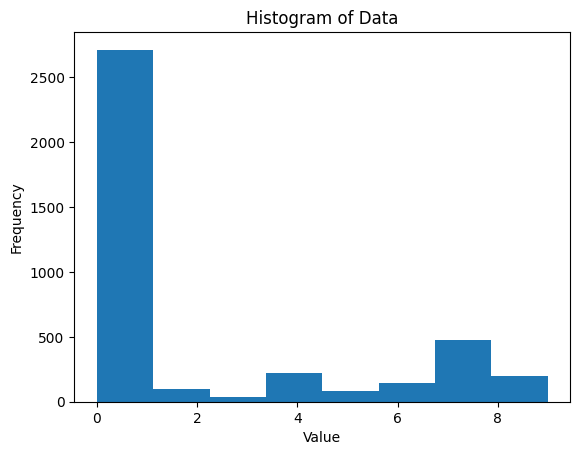

In [ ]:
plt.hist(cluster_labels, bins=8)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
plt.show()

transition graph:

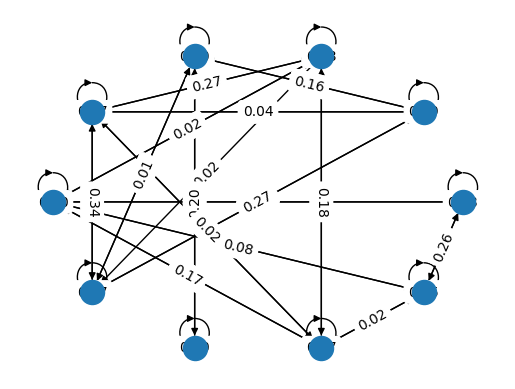

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# define the transition matrix
P = transition_matrix

# create a directed graph
G = nx.DiGraph()

# add nodes to the graph
for i in range(P.shape[0]):
    G.add_node(i)

# add edges to the graph
for i in range(P.shape[0]):
    for j in range(P.shape[1]):
        if P[i,j] > 0:
            G.add_edge(i, j, weight=P[i,j])

# set the positions of the nodes in the graph
pos = nx.circular_layout(G)

# draw the nodes and edges of the graph
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)

# add edge labels to the graph
edge_labels = {(i, j): "{:.2f}".format(P[i,j]) for i, j in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# display the graph
plt.axis("off")
plt.show()


In [ ]:
plt.plot(loss_list)
plt.title("Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
tsne = TSNE(n_components=3, perplexity=30, random_state=0)
embedded_3d = tsne.fit_transform(embeddings2)

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
embedded_2d = tsne.fit_transform(embeddings2)

In [ ]:
np.save('/content/drive/MyDrive/SocioSent/embedded_2d.npy', embedded_2d)
np.save('/content/drive/MyDrive/SocioSent/embedded_3d.npy', embedded_3d)

In [ ]:
embedded_3d = np.load('/content/drive/MyDrive/SocioSent/embedded_3d.npy')
embedded_2d = np.load('/content/drive/MyDrive/SocioSent/embedded_2d.npy')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/SocioSent/labels.csv', index_col=None, header=None, encoding="utf-8")

In [ ]:
import collections

labels = []#np.zeros([1,Xs.shape[1]])
embeds = []
embeds_3d = []
embeds_2d = []
n = 120
len = df.shape[0]
overlap = 0.5
step_size = 10
graph_of_frame = []

# count = collections.Counter(my_list)
# most_common = count.most_common(1)[0][0]

for i in range(0, 120):
  idx = 0
  count = collections.Counter(cluster_labels[idx:idx+4])
  lab = count.most_common(1)[0][0]
  labels.append(lab)
  embeds.append(embeddings2[idx+2,:])
  embeds_2d.append(embedded_2d[idx+2,:])
  embeds_3d.append(embedded_3d[idx+2,:])
  graph_of_frame.append(idx)

for i in range(120, len-120):
  step = i // step_size
  idx = step - 4
  count = collections.Counter(cluster_labels[idx:idx+4])
  lab = count.most_common(1)[0][0]
  labels.append(lab)
  embeds.append(embeddings2[idx+2,:])
  embeds_2d.append(embedded_2d[idx+2,:])
  embeds_3d.append(embedded_3d[idx+2,:])
  graph_of_frame.append(idx+2)

for i in range(len-120, len):
  # step = len - 120 // step_size
  idx = len - 120
  count = collections.Counter(cluster_labels[idx:idx+4])
  lab = 0 #count.most_common(1)[0][0]
  labels.append(lab)
  embeds.append(embeddings2[2,:])
  embeds_2d.append(embedded_2d[2,:])
  embeds_3d.append(embedded_3d[2,:])
  graph_of_frame.append(embedded_3d.shape[0])

# for _ in range(int(n*0.25)):
#     labels.append(cluster_labels[0])
#     embeds.append(embeddings2[0,:])

# for i in range(graph_num):
#   for _ in range(int(n*0.5)):
#     labels.append(cluster_labels[i])
#     embeds.append(embeddings2[i,:])

# for _ in range(int(50)):
#     labels.append(cluster_labels[graph_num-1])
#     embeds.append(embeddings2[graph_num-1,:])

  # labels[idx*n:(idx*n+n)] = la*np.ones([1,graph_num])
# labels[idx:idx+n] = la

embeds_3d = np.array(embeds_3d)
embeds_2d = np.array(embeds_2d)
graph_of_frame = np.array(graph_of_frame)

In [ ]:
print(labels[1000:1500])

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [ ]:
df = pd.DataFrame(labels)
df.to_csv('/content/drive/MyDrive/SocioSent/frame_lablels.csv', index=False)

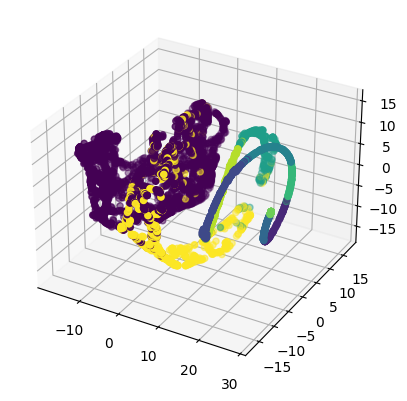

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# assume your embedded graphs are stored in a numpy array called 'embedded_graphs'
# with shape (6, 927)
embedded_graphs = embeddings2.T

# reduce the dimensionality of the embedded graphs to 3D using t-SNE
# tsne = TSNE(n_components=3, perplexity=30, random_state=0)
# embedded_3d = tsne.fit_transform(embedded_graphs.T)

# create a 3D scatter plot of the embedded graphs
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(embedded_3d[:,0], embedded_3d[:,1], embedded_3d[:,2], c=cluster_labels)
plt.show()


In [ ]:
embeds = np.array(embeds)

In [ ]:
# np.savetxt('/content/drive/MyDrive/SocioSent/embeds_3d.csv', embeds_3d, delimiter=',')
# np.savetxt('/content/drive/MyDrive/SocioSent/embeds_2d.csv', embeds_2d, delimiter=',')
np.savetxt('/content/graph_of_frame.csv', graph_of_frame, delimiter=',')